In [1]:
from geomdl import NURBS
from geomdl import BSpline
from geomdl.visualization import VisMPL
from geomdl import multi
import numpy as np
from matplotlib import cm
from clifford.tools.g3c import *
from clifford.tools.g3c.rotor_parameterisation import *
from pyganja import *


Failed to import cef_gui, cef functions will be unavailable


In [2]:
def list_to_CGA(x):
    c = + x[0]*e1 + x[1]*e2 - x[2]*e3
    return up(c)

In [3]:
#Define the 2 vectors and 2 tangents

v1 = [2,3,0]
m1 = [6,-12, 0]
v4 = [17,8,0]
m4 = [3,6,0]

#Define the vector normals

m1_norm = [m1[i]/np.linalg.norm(m1) for i in range(3)]
m4_norm = [m4[i]/np.linalg.norm(m4) for i in range(3)]



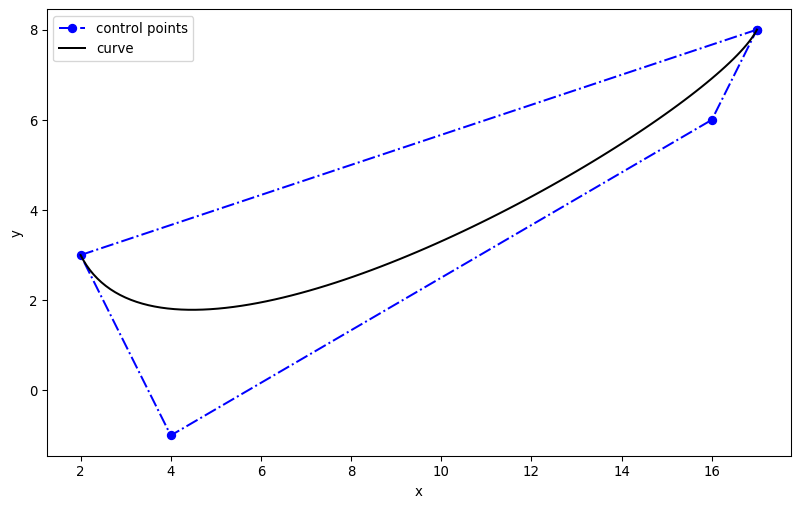

In [25]:
#Convert to Bezier Control Points
p0 = v1
p1 = [v1[i] + m1[i]/3 for i in range(3)]
p2 = [v4[i]- m4[i]/3 for i in range(3)]
p3 = v4

#Sketch NURBS with weights 1

crv = NURBS.Curve()
crv.degree = 3
crv.ctrlptsw = [p3 + [1], p0 + [1], p1 + [1], p2 + [1], p3 + [1]]
crv.knotvector = [0, 0, 0, 0, 0, 1, 1, 1, 1]

crv.vis = VisMPL.VisCurve2D()
crv.render()




In [5]:
NURBS_points = [list_to_CGA(crv.evalpts[i]) for i,j in enumerate(crv.evalpts)]
NURBS_pp_list = [NURBS_points[i]^NURBS_points[i+1] for i in range(len(crv.evalpts)-1)]

In [28]:
#switch p0, p1, p2 and p3 to CGA
P0 = list_to_CGA(p0)
P1 = list_to_CGA(p1)
P2 = list_to_CGA(p2)
P3 = list_to_CGA(p3)

#Unit Circle at the origin
C0 = (up(e1)^up(e2)^up(-e1)).normal()

#Form the boundary using point pairs
point_list = [P0, P1, P2, P3]
boundary_pp_list = [point_list[i]^point_list[(i+1) % 4] for i in range(4)]

#Form the first sphere, radius matching 1/3rd of |m1|
modm1 = np.linalg.norm(np.array(p0)-np.array(p1))
Sp1 = (P0 - 0.5*modm1**2*einf)*I5

#Form the first plane, vector definition using normalised m1 (must be downconverted from CGA),
#distance by dot product of normal with point. Correct sign must be picked
Pl1 = (down(list_to_CGA(m1_norm)) - np.abs(np.dot(v1,m1_norm))*einf)*I5
Ci1 = meet(Sp1,Pl1)

modm2 = np.linalg.norm(np.array(p3)-np.array(p2))
Sp2 = (P3 - 0.5*modm2**2*einf)*I5
Pl2 = (down(list_to_CGA(m4_norm)) + np.abs(np.dot(v4,m4_norm))*einf)*I5
Ci2 = meet(Sp2,Pl2)


def TRS_from_origin(C1, C2, it=40):
    R1 = TRS_between_rounds(C0, C1)
    R2 = TRS_between_rounds(C0, C2)
    R = R2*~R1
    logR = general_logarithm(R)
    return [general_exp((1/it)*alpha*logR)
              for alpha in range(it)]

def TRS_between_circles(C1, C2, it=40):
    R = TRS_between_rounds(C1, C2)
    logR = general_logarithm(R)
    return [general_exp((1/it)*alpha*logR)
              for alpha in range(it)]

def RBO_from_origin(C1, C2, it=40):
    R1 = rotor_between_objects(C0, C1)
    R2 = rotor_between_objects(C0, C2)
    R = R2*~R1
    logR = general_logarithm(R)
    return [general_exp((1/it)*alpha*logR)
              for alpha in range(it)]

def RBO_between_circles(C1, C2, it=40):
    R = rotor_between_objects(C1, C2)
    logR = general_logarithm(R)
    return [general_exp((1/it)*alpha*logR)
              for alpha in range(it)]

def av_between_circles(C1, C2, it=40):
    return [average_objects([C1,C2], [alpha, 1-alpha]) for alpha in np.linspace(0,1,it)]

#rotor_list = TRS_between_circles(Ci1, Ci2, 40)

# Apply the interpolated rotors
#circle_list = [R_int*Ci1*~R_int for R_int in rotor_list]

circle_list = av_between_circles(Ci1,Ci2)

centre_list = [normalise_n_minus_1((C*einf*C)(1)) for C in circle_list]

centre_pp_list = [centre_list[i]^centre_list[i+1] for i in range(39)]



sc = GanjaScene()






sc.add_objects([o(2).normal().clean(1E-4) for o in boundary_pp_list], color.Color.BLUE)
sc.add_objects([o(2).normal().clean(1E-4) for o in NURBS_pp_list], color.Color.RED)
sc.add_objects([o(2).normal().clean(1E-4) for o in centre_pp_list], color.Color.BLACK)
#sc.add_objects([o(3).normal().clean(1E-4) for o in circle_list], color.Color.BLACK)

sc.add_objects([Ci1])
sc.add_objects([Ci2])


draw(sc, 
    static=False , 
    scale=0.1)




<IPython.core.display.Javascript object>

In [24]:
T =  general_exp(-20*einf^(down(P3))/2)
C_or = T*Ci2*~T

In [18]:
sc = GanjaScene()







sc.add_objects([C_or])



draw(sc, 
    static=False , 
    scale=0.1)

<IPython.core.display.Javascript object>